In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy as sp
import plotly.graph_objs as go
from sklearn import metrics

from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style='white')
#%config InlineBackend.figure_format = 'retina'
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import ensemble, decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


In [5]:
owid = pd.read_csv('./covid-19-data-master/public/data/owid-covid-data.csv')
oxcgrt = pd.read_csv('./covid-policy-tracker-master/data/OxCGRT_latest.csv')
startdate1 = '2020-12-01'
startdate2 = '2021-01-01'
startdate3 = '2021-04-01'

In [131]:
owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97992 entries, 0 to 97991
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               97992 non-null  object 
 1   continent                              93386 non-null  object 
 2   location                               97992 non-null  object 
 3   date                                   97992 non-null  object 
 4   total_cases                            94574 non-null  float64
 5   new_cases                              94571 non-null  float64
 6   new_cases_smoothed                     93561 non-null  float64
 7   total_deaths                           84491 non-null  float64
 8   new_deaths                             84647 non-null  float64
 9   new_deaths_smoothed                    93561 non-null  float64
 10  total_cases_per_million                94070 non-null  float64
 11  ne

In [ ]:
def build_model(model_name):
    if model_name == 'linear':
        model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('linear', LinearRegression(fit_intercept=False))])
    elif model_name == 'xgboost':
        model =  xgb.XGBRegressor(n_estimators=20000,max_depth=5,reg_lambda=0.9, random_state=42)
        model.fit(X_train, y_train, early_stopping_rounds=300, eval_set=[(X_test, y_test)], verbose=False)
    elif model_name == 'linearregression':
        model = linear_model.LinearRegression()
    elif model_name == 'randomforest':
        model = RandomForestRegressor()
        model1 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
        model = Pipeline([('scaler2' , StandardScaler()),
                                ('RandomForestRegressor: ', model1)])
    elif model_name == 'decisiontree':
        model = DecisionTreeClassifier()
    return model


In [3]:
owid2=owid.dropna(subset=['new_cases_smoothed','new_deaths_smoothed'])

constant = ['population','population_density','median_age','aged_65_older','aged_70_older','gdp_per_capita',
           'cardiovasc_death_rate','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy','human_development_index']

In [125]:
#prepare data
predict_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','stringency_index']
NLD_data = owid[owid['iso_code']=='NLD'][predict_NLDOWID]

In [126]:
#check data
NLD_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 62211 to 62694
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                484 non-null    object 
 1   reproduction_rate   473 non-null    float64
 2   new_cases           484 non-null    float64
 3   new_deaths          476 non-null    float64
 4   icu_patients        480 non-null    float64
 5   hosp_patients       478 non-null    float64
 6   new_tests_smoothed  449 non-null    float64
 7   stringency_index    478 non-null    float64
dtypes: float64(7), object(1)
memory usage: 34.0+ KB


In [133]:
f, ax= plt.subplots(figsize = (14, 10))
corr = NLD_data.corr()
# print(corr)
sns.heatmap(corr,cmap='RdBu', linewidths = 0.05, ax = ax,annot=True)
ax.set_title('Correlation between features')
plt.show()
import scipy.stats as st
def ch2_test(data1,data2):
    this = pd.crosstab(data1, data2)
    return st.chi2_contingency(this)[1]

def find_corr_sig(df,criterion=0.05):
    sig = {}
    for i in df.columns:
        for j in df.columns:
            if i != j:
                p_n = ch2_test(df[i],df[j])
                if p_n<criterion:
                    print(f'the p value between {i} and {j} is {p_n}')
                    sig[i+' '+j] = p_n
    return sig
s = find_corr_sig(NLD_data,)

the p value between reproduction_rate and stringency_index is 4.8207694682600145e-165
the p value between new_cases and icu_patients is 0.0032281264202751007
the p value between new_cases and hosp_patients is 0.03655218023699586
the p value between new_deaths and icu_patients is 8.545294227847566e-31
the p value between new_deaths and hosp_patients is 2.603379366179303e-15
the p value between icu_patients and new_cases is 0.0032281264202751007
the p value between icu_patients and new_deaths is 8.545294227847566e-31
the p value between icu_patients and hosp_patients is 3.418746937158633e-24
the p value between icu_patients and stringency_index is 0.0001404005998983155
the p value between hosp_patients and new_cases is 0.036552180237003476
the p value between hosp_patients and new_deaths is 2.603379366179303e-15
the p value between hosp_patients and icu_patients is 3.418746937158633e-24
the p value between hosp_patients and stringency_index is 4.128269621654032e-06
the p value between st

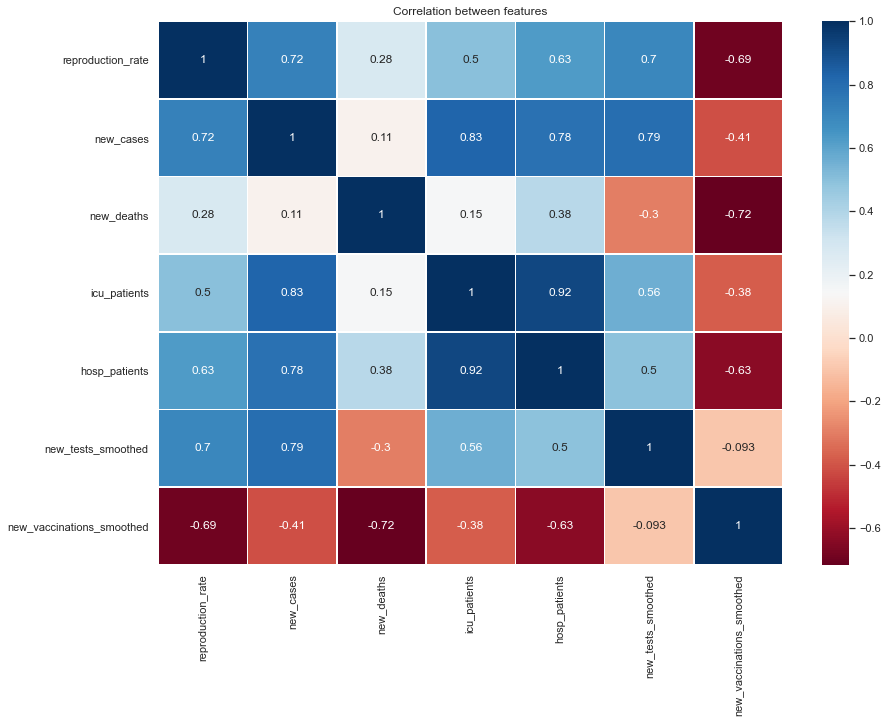

the p value between reproduction_rate and icu_patients is 0.04572825604648127
the p value between reproduction_rate and hosp_patients is 0.05015301933731097
the p value between icu_patients and reproduction_rate is 0.04572825604648127
the p value between icu_patients and hosp_patients is 0.13934946845916693
the p value between hosp_patients and reproduction_rate is 0.050153019337311734
the p value between hosp_patients and icu_patients is 0.13934946845916693
the p value between new_tests_smoothed and new_vaccinations_smoothed is 0.19012923719227973
the p value between new_vaccinations_smoothed and new_tests_smoothed is 0.19012923719227973


In [144]:
#EDA
c_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','new_vaccinations_smoothed']
NLD_jan_data = owid[owid['iso_code']=='NLD'][c_NLDOWID]
NLD_jan_data['date'] = pd.to_datetime(NLD_jan_data['date'], format = '%Y-%m-%d')
NLD_jan_data = NLD_jan_data[NLD_jan_data['date']>'2021-01-15']
f, ax= plt.subplots(figsize = (14, 10))
corr = NLD_jan_data.corr()
# print(corr)
sns.heatmap(corr,cmap='RdBu', linewidths = 0.5, ax = ax,annot=True)
ax.set_title('Correlation between features')
plt.show()
s = find_corr_sig(NLD_jan_data,0.2)

In [145]:
# pre-processing and fillna
NLD_data1 = NLD_data.fillna(method='pad') 
NLD_data1 = NLD_data1.fillna(method='bfill')
l = LabelEncoder()
X = NLD_data1.iloc[:,0].values
NLD_data1.iloc[:,0] = l.fit_transform(X.astype(str))

In [146]:
beginning = NLD_data.date.min()
last = NLD_data.date.max()

In [147]:
europe_country_list = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU','SVK','SVN','ESP','SWE','GBR']
europe_country_list = ['AUT','BEL','BGR','HRV','CZE','DNK','EST','FRA','DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','NLD','POL','PRT','ROU','SVK','SVN','ESP','SWE','GBR']
world_cols = ['OWID_AFR','OWID_ASI','OWID_EUR','OWID_EUN','OWID_INT',
              'OWID_KOS','OWID_NAM','OWID_CYN','OWID_OCE','OWID_SAM','OWID_WRL']
country_list = ['NLD','IND','USA','BRA','NER']
country_list = ['NLD','IND','USA','BRA']
add_list = ['BES','CUW','SXM','SSD']

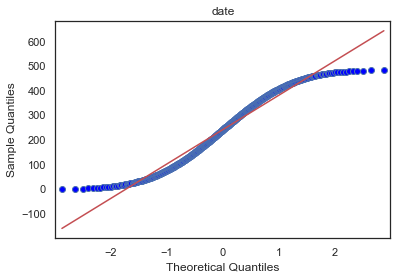

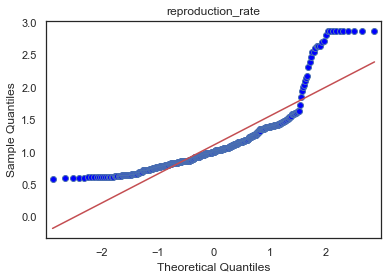

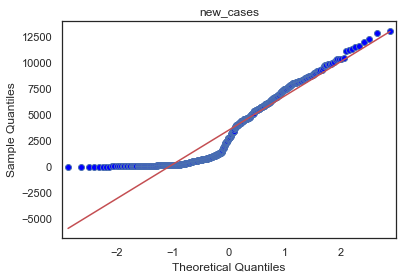

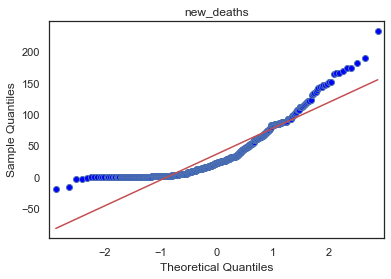

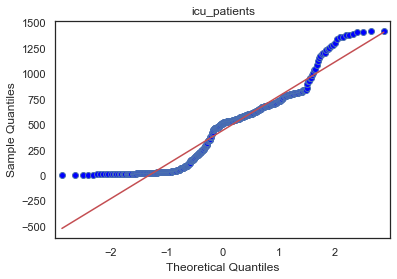

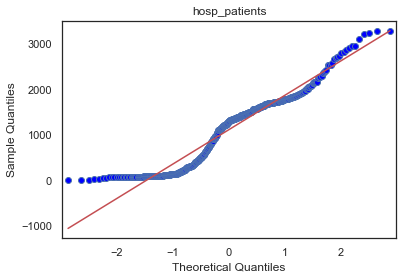

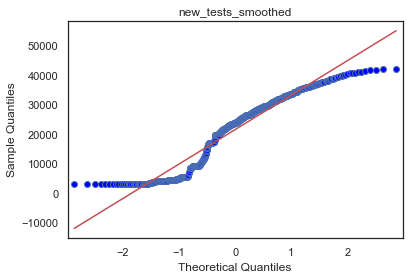

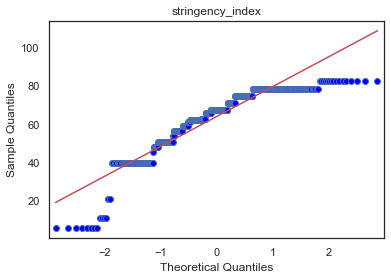

The data can be considered normally distributed - albeit the first plot (total deaths) runs a bit from the line.


In [148]:
'''
Verify normal distribution with, for example, a q-q plot, which
compares our data with a Gaussian distribution (or normal distribution)
'''
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

for i in NLD_data1.columns:
# q-q plot
    qqplot(NLD_data1[i], line='s')
    plt.title(i)
    pyplot.show()
print('The data can be considered normally distributed - albeit the first plot (total deaths) runs a bit from the line.')

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


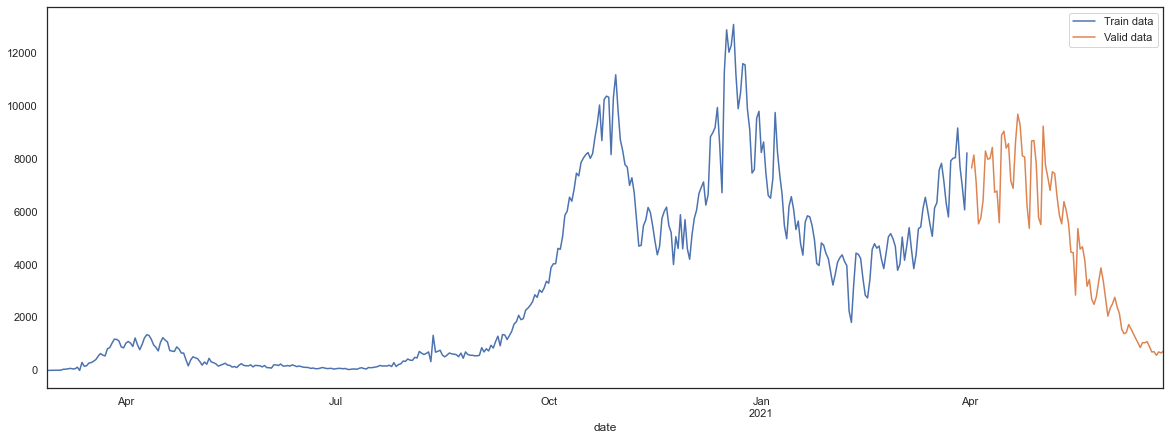

In [150]:
#split data for predicting NL
import datetime
startdate1 = '2020-12-01'
startdate2 = '2021-01-01'
startdate3 = '2021-04-01'
predict_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','stringency_index']
NLD_data = owid[owid['iso_code']=='NLD'][predict_NLDOWID]

NLD_data1 = NLD_data.fillna(method='pad') 
NLD_data1 = NLD_data1.fillna(method='bfill')

NLD_data2 = NLD_data1.drop(['new_cases','new_deaths'],axis=True)
l = LabelEncoder()

startdate = startdate3
test = NLD_data2[NLD_data1.date>startdate]
train = NLD_data2[NLD_data1.date<=startdate]

X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))

X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))


y_train = NLD_data1[NLD_data1.date<=startdate]['new_cases']
y_test = NLD_data1[NLD_data1.date>startdate]['new_cases']
x_train= train
x_test = test

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')
x_test=test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y-%m-%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]
plt.figure(figsize=(20,7))

train_data.new_cases.plot(label='Train data')
valid_data.new_cases.plot(label='Valid data')
plt.legend(loc='best')

In [157]:
# Predicting new cases on owid dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)

model11 = Pipeline([('scaler2' , StandardScaler()),
                ('LinearRegression: ', LinearRegression())]) 
model11.fit(x_train , y_train)
prediction = model11.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression with standard scaling data',acc)

model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with standard scaling', acc)
acc_list.append(acc)

model5 = SVR(kernel = 'linear')
model5.fit(x_train , y_train)
prediction = model5.predict(x_test)
acc=model5.score(x_test,y_test)
print('SVR with linear kernel', acc)
acc_list.append(acc)

model6 = SVR(kernel = 'rbf')
model6.fit(x_train , y_train)
prediction = model6.predict(x_test)
acc=model6.score(x_test,y_test)
print('SVR with rbf kernel', acc)
acc_list.append(acc)

y_pred = model1.predict(x_test)
NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y%m%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]
result_data = valid_data.copy()
result_data['new_cases'] = y_pred
result_data1 = valid_data.copy()
result_data1['new_cases'] = mode144.predict(x_test)
result_data2 = valid_data.copy()
result_data2['new_cases'] = model5.predict(x_test)
plt.figure(figsize=(20,7))
# plt.plot(model1.predict(x_test))
train_data.new_cases.plot(label='Training')
valid_data.new_cases.plot(label='Validation')
result_data.new_cases.plot(label='Prediction of Linear Regression')
result_data1.new_cases.plot(label='Prediction of Random Forest')
result_data2.new_cases.plot(label='Prediction of SVR with linear')

plt.legend(loc='best')
plt.show()

LinearRegression 0.8587756149664723
LinearRegression with standard scaling data 0.8587756149664723
ExtraTreesRegressor 0.6559423319387161
Linear Regression with PolynomialFeatures -49.95667461969543
Random Forest -1.446190312651427
Random Forest with standard scaling -1.2972963881768989
SVR with linear kernel 0.3771275093644413
SVR with rbf kernel -1.386394839088684


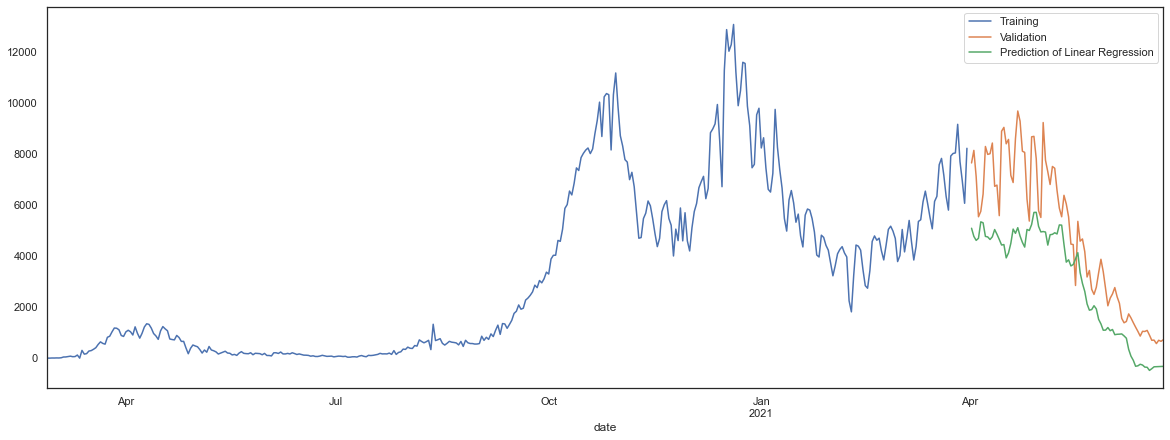

In [153]:
y_pred = model1.predict(x_test)
NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y%m%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]
result_data = valid_data.copy()
result_data['new_cases'] = y_pred
plt.figure(figsize=(20,7))
# plt.plot(model1.predict(x_test))
train_data.new_cases.plot(label='Training')
valid_data.new_cases.plot(label='Validation')
result_data.new_cases.plot(label='Prediction of Linear Regression')
plt.legend(loc='best')
plt.show()

In [158]:
# import statsmodels.formula.api as smf
import statsmodels.api as sm
model=sm.OLS(y_train,x_train)
results=model.fit()
print(results.summary())
model=sm.OLS(y_train,x_train.drop('date',axis=True))
results=model.fit()
results.summary()

                                 OLS Regression Results                                
Dep. Variable:              new_cases   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              643.0
Date:                Sun, 27 Jun 2021   Prob (F-statistic):                   4.87e-200
Time:                        09:42:10   Log-Likelihood:                         -3469.7
No. Observations:                 400   AIC:                                      6951.
Df Residuals:                     394   BIC:                                      6975.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              new_cases   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              773.5
Date:                Sun, 27 Jun 2021   Prob (F-statistic):                   1.69e-201
Time:                        09:42:10   Log-Likelihood:                         -3469.7
No. Observations:                 400   AIC:                                      6949.
Df Residuals:                     395   BIC:                                      6969.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
reproduction_rate   -577.4329    109.734     -5.262      0.000    -793.169    -361.697
icu_patients          -4.2588      0.679     -6.269      0.000      -5.594      -2.923
hosp_patients          4.0384      0.299     13.484      0.000       3.450       4.627
new_tests_smoothed     0.2043      0.006     31.867      0.000       0.192       0.217
stringency_index     -43.8076      3.935    -11.133      0.000     -51.543     -36.072
==============================================================================
Omnibus:                       32.955   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.266
Skew:                           0.446   Prob(JB):                     3.35e-16
Kurtosis:                       4.866   Cond. No.                     3.57e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
plt.bar(range(6),model1.coef_)
plt.xticks(range(6),x_train.columns,rotation=80)


([<matplotlib.axis.XTick at 0x7fd0b8583430>,
 [Text(0, 0, 'date'),
  Text(1, 0, 'reproduction_rate'),
  Text(2, 0, 'icu_patients'),
  Text(3, 0, 'hosp_patients'),
  Text(4, 0, 'new_tests_smoothed'),
  Text(5, 0, 'stringency_index')])

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


LinearRegression -20.762107847382428
LinearRegression with standard scaling data -20.762107847382428
ExtraTreesRegressor -35.895236131003514
Linear Regression with PolynomialFeatures -114.71101372500014
Random Forest -29.193459096724904
Random Forest with standard scaling -30.79274973436455
SVR with linear kernel -35.687451148101495
SVR with rbf kernel -1.578668839140097


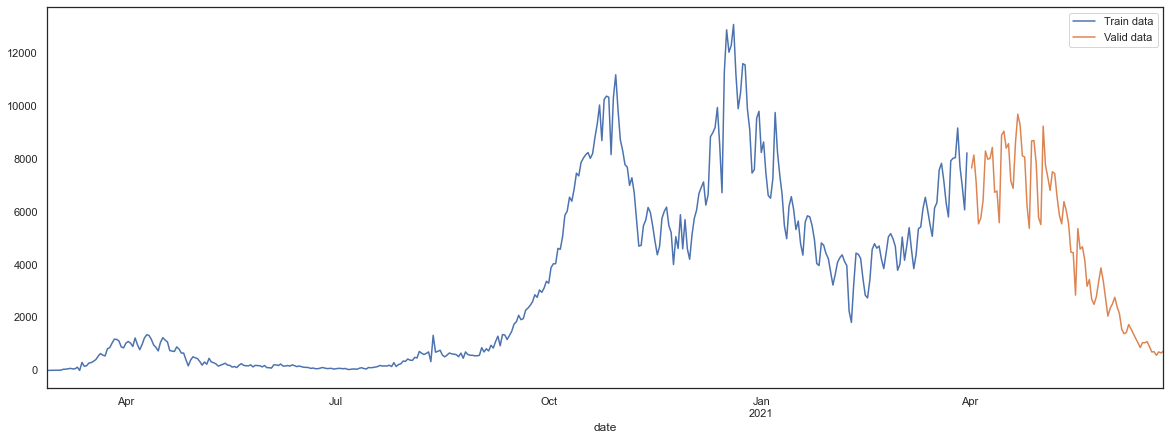

In [159]:
predict_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','stringency_index']
NLD_data = owid[owid['iso_code']=='NLD'][predict_NLDOWID]

NLD_data1 = NLD_data.fillna(method='pad') 
NLD_data1 = NLD_data1.fillna(method='bfill')

NLD_data2 = NLD_data1.drop(['new_cases','new_deaths'],axis=True)
l = LabelEncoder()

startdate = startdate3
test = NLD_data2[NLD_data1.date>startdate]
train = NLD_data2[NLD_data1.date<=startdate]

X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))

X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))


y_train = NLD_data1[NLD_data1.date<=startdate]['new_deaths']
y_test = NLD_data1[NLD_data1.date>startdate]['new_deaths']
x_train= train
x_test = test

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')
x_test=test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y-%m-%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<=startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]
plt.figure(figsize=(20,7))

train_data.new_cases.plot(label='Train data')
valid_data.new_cases.plot(label='Valid data')
plt.legend(loc='best')
# Predicting new cases on owid dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)

model11 = Pipeline([('scaler2' , StandardScaler()),
                ('LinearRegression: ', LinearRegression())]) 
model11.fit(x_train , y_train)
prediction = model11.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression with standard scaling data',acc)

model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with standard scaling', acc)
acc_list.append(acc)

model5 = SVR(kernel = 'linear')
model5.fit(x_train , y_train)
prediction = model5.predict(x_test)
acc=model5.score(x_test,y_test)
print('SVR with linear kernel', acc)
acc_list.append(acc)

model6 = SVR(kernel = 'rbf')
model6.fit(x_train , y_train)
prediction = model6.predict(x_test)
acc=model6.score(x_test,y_test)
print('SVR with rbf kernel', acc)
acc_list.append(acc)

y_pred = model1.predict(x_test)
NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y%m%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]
result_data = valid_data.copy()
result_data['new_cases'] = y_pred
result_data1 = valid_data.copy()
result_data1['new_cases'] = mode144.predict(x_test)
result_data2 = valid_data.copy()
result_data2['new_cases'] = model5.predict(x_test)
plt.figure(figsize=(20,7))
# plt.plot(model1.predict(x_test))
train_data.new_cases.plot(label='Training')
valid_data.new_cases.plot(label='Validation')
result_data.new_cases.plot(label='Prediction of Linear Regression')
result_data1.new_cases.plot(label='Prediction of Random Forest')
result_data2.new_cases.plot(label='Prediction of SVR with linear')

plt.legend(loc='best')
plt.show()

In [15]:
#split data on oxcg dataset during time and predict confirm cases
oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format = '%Y%m%d')
train2 = oxcgrt.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
drop2 = ['C1_Flag','C2_Flag','C3_Flag','C4_Flag','C5_Flag','C6_Flag','C7_Flag','H1_Flag','H7_Flag','H8_Flag','M1_Wildcard',
        'E4_International support']
train2 = train2.drop(drop2,axis=True)
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
# train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)
startdate=startdate3
test = train2[train2.Date>startdate]
train = train2[train2.Date<=startdate]

l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
X = train.iloc[:,3].values
train.iloc[:,3] = l.fit_transform(X.astype(str))
X = train.iloc[:,4].values
train.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

l = LabelEncoder()
X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))
X = test.iloc[:,1].values
test.iloc[:,1] = l.fit_transform(X.astype(str))
X = test.iloc[:,2].values
test.iloc[:,2] = l.fit_transform(X.astype(str))
X = test.iloc[:,3].values
test.iloc[:,3] = l.fit_transform(X.astype(str))
X = test.iloc[:,4].values
test.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train.columns)):
    X = test.iloc[:,i].values
    test.iloc[:,i]= l.fit_transform(X.astype(float))

y_train = oxcgrt[oxcgrt.Date<=startdate]['ConfirmedCases']
y_test = oxcgrt[oxcgrt.Date>startdate]['ConfirmedCases']

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train =train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

x_test =test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
def train_model_ox(x_train,y_train,x_test,y_test,df,startdate):
    acc_list=[]
    model1 = LinearRegression()
    model1.fit(x_train , y_train)
    prediction = model1.predict(x_test)
    acc=model1.score(x_test,y_test)
    acc_list.append(acc)
    print('LinearRegression',acc)

    model22 = Pipeline([('scaler2' , StandardScaler()),
                    ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
    model22.fit(x_train , y_train)
    prediction = model22.predict(x_test)
    acc=model22.score(x_test,y_test)
    print('ExtraTreesRegressor',acc)
    acc_list.append(acc)

    acc_list.append(acc)
    model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                 ('linear', LinearRegression(fit_intercept=False))])
    model3.fit(x_train , y_train)
    prediction = model3.predict(x_test)
    acc=model3.score(x_test,y_test)
    print('Linear Regression with PolynomialFeatures',acc)
    acc_list.append(acc)

    model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
    model4.fit(x_train , y_train)
    prediction = model4.predict(x_test)
    acc=model4.score(x_test,y_test)
    print('Random Forest',acc)
    acc_list.append(acc)

    mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
    mode144.fit(x_train , y_train)
    prediction = mode144.predict(x_test)
    acc=mode144.score(x_test,y_test)
    print('Random Forest with scaling', acc)
    acc_list.append(acc)

    # model5 = SVR(kernel = 'linear')
    # model5.fit(x_train , y_train)
    # prediction = model5.predict(x_test)
    # acc=model5.score(x_test,y_test)
    # print('SVR with linear kernel', acc)
    # acc_list.append(acc)

    # model6 = SVR(kernel = 'rbf')
    # model6.fit(x_train , y_train)
    # prediction = model6.predict(x_test)
    # acc=model6.score(x_test,y_test)
    # print('SVR with rbf kernel', acc)
    # acc_list.append(acc)

    if acc_list[3]>0.6:

        #plot feature importance
        importances = model4.feature_importances_
        indices = np.argsort(importances)[::-1]
        for f in range(x_train.shape[1]):
            print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
        plt.title('feature importance')
        # plt.figure(figsize=(10,20))
        n=6
        plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
        plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
        plt.tight_layout()

    y_pred = model1.predict(x_test)
    NLD_data1=oxcgrt.set_index(df.Date)
    train_data=NLD_data1[NLD_data1['Date']<startdate]
    valid_data=NLD_data1[NLD_data1['Date']>startdate]
    result_data = valid_data.copy()
    result_data['ConfirmedCases'] = y_pred
    result_data1 = valid_data.copy()
    result_data1['ConfirmedCases'] = mode144.predict(x_test)
    # result_data2 = valid_data.copy()
    # result_data2['ConfirmedCases'] = model5.predict(x_test)
    plt.figure(figsize=(20,7))
    # plt.plot(model1.predict(x_test))
    train_data.ConfirmedCases.plot(label='Training')
    valid_data.ConfirmedCases.plot(label='Validation')
    result_data.ConfirmedCases.plot(label='Prediction of Linear Regression')
    result_data1.ConfirmedCases.plot(label='Prediction of Random Forest')
    # result_data2.new_cases.plot(label='Prediction of SVR with linear')

    plt.legend(loc='best')
    plt.show()
train_model_ox(x_train,y_train,x_test,y_test,oxcgrt,startdate)



/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


LinearRegression -0.06906296508160659
ExtraTreesRegressor -0.10014086393755117
Linear Regression with PolynomialFeatures -8413.135036442
Random Forest 0.027681620592453493
Random Forest with scaling 0.07061685223048508


In [18]:
# Predicting new cases on owid dataset all countries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
def train_model_owid(x_train,y_train,x_test,y_test,NLD_data1,startdate):
    acc_list=[]
    model1 = LinearRegression()
    model1.fit(x_train , y_train)
    prediction = model1.predict(x_test)
    acc=model1.score(x_test,y_test)
    acc_list.append(acc)
    print('LinearRegression',acc)

    model11 = Pipeline([('scaler2' , StandardScaler()),
                 ('linear', LinearRegression())])
    model11.fit(x_train , y_train)
    prediction = model11.predict(x_test)
    acc=model11.score(x_test,y_test)
    print('Linear Regression with Scaling',acc)
    model22 = Pipeline([('scaler2' , StandardScaler()),
                    ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=500))]) # On competition I set n_estimators=500
    model22.fit(x_train , y_train)
    prediction = model22.predict(x_test)
    acc=model22.score(x_test,y_test)
    print('ExtraTreesRegressor',acc)
    acc_list.append(acc)

    acc_list.append(acc)
    model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                 ('linear', LinearRegression(fit_intercept=False))])
    model3.fit(x_train , y_train)
    prediction = model3.predict(x_test)
    acc=model3.score(x_test,y_test)
    print('Linear Regression with PolynomialFeatures',acc)
    acc_list.append(acc)

    model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 500)
    model4.fit(x_train , y_train)
    prediction = model4.predict(x_test)
    acc=model4.score(x_test,y_test)
    print('Random Forest',acc)
    acc_list.append(acc)

    mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
    mode144.fit(x_train , y_train)
    prediction = mode144.predict(x_test)
    acc=mode144.score(x_test,y_test)
    print('Random Forest with scaling', acc)
    acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)
    if acc_list[3]>0.7:
        #plot feature importance
        importances = model4.feature_importances_
        indices = np.argsort(importances)[::-1]
        for f in range(x_train.shape[1]):
            print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
        plt.title('feature importance')
        # plt.figure(figsize=(10,20))
        n=15
        plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
        plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
        plt.tight_layout()
    y_pred = model1.predict(x_test)
    NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y%m%d')
    NLD_data1=NLD_data1.set_index(NLD_data1.date)
    train_data=NLD_data1[NLD_data1['date']<startdate]
    valid_data=NLD_data1[NLD_data1['date']>startdate]
    result_data = valid_data.copy()
    result_data['new_cases'] = y_pred
    result_data1 = valid_data.copy()
    result_data1['new_cases'] = mode144.predict(x_test)
    result_data2 = valid_data.copy()
    result_data2['new_cases'] = model5.predict(x_test)
    plt.figure(figsize=(20,7))
    # plt.plot(model1.predict(x_test))
    train_data.new_cases.plot(label='Training')
    valid_data.new_cases.plot(label='Validation')
    result_data.new_cases.plot(label='Prediction of Linear Regression')
    result_data1.new_cases.plot(label='Prediction of Random Forest')
    result_data2.new_cases.plot(label='Prediction of SVR with linear')

    plt.legend(loc='best')
    plt.show()
train_model_owid(x_train,y_train,x_test,y_test,NLD_data1,startdate)

LinearRegression 0.21513001789988473
Linear Regression with Scaling 0.18999865765408575
ExtraTreesRegressor 0.9943741728625642
Linear Regression with PolynomialFeatures 0.7935596725587049
Random Forest 0.9974303223605058
Random Forest with scaling 0.9967607324749773


In [19]:
#randomly split data on owid dataset and predict new deaths
train = owid2.drop(['new_cases_per_million','total_cases','new_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths','new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million','tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)

owid2=owid.dropna(subset=['new_deaths_smoothed'])
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

y_train=owid2['new_deaths_smoothed']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train=train
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
# Predicting new cases 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()


LinearRegression 0.2611718893679851
ExtraTreesRegressor 0.9976554536187691
Linear Regression with PolynomialFeatures 0.859927721484216
Random Forest 0.9984307351917694
Random Forest with scaling 0.9982993145374641
 1) population                     0.318647
 2) date                           0.102225
 3) diabetes_prevalence            0.101066
 4) weekly_icu_admissions_per_million 0.082220
 5) location                       0.075701
 6) reproduction_rate              0.055976
 7) people_vaccinated_per_hundred  0.047886
 8) total_tests_per_thousand       0.038600
 9) stringency_index               0.037621
10) continent                      0.025383
11) population_density             0.007889
12) new_tests_per_thousand         0.007688
13) iso_code                       0.007529
14) handwashing_facilities         0.007028
15) excess_mortality               0.006034
16) weekly_icu_admissions          0.005615
17) aged_70_older                  0.005140
18) tests_per_case                 

LinearRegression 0.2611718893679851
ExtraTreesRegressor 0.9983693530185624
Linear Regression with PolynomialFeatures 0.859927721484216
Random Forest 0.9983932519998203
Random Forest with scaling 0.9986030459428371
 1) population                     0.301821
 2) date                           0.101976
 3) location                       0.089862
 4) diabetes_prevalence            0.079136
 5) reproduction_rate              0.065748
 6) weekly_icu_admissions_per_million 0.058439
 7) stringency_index               0.054953
 8) total_tests_per_thousand       0.046902
 9) people_vaccinated_per_hundred  0.045260
10) continent                      0.039492
11) population_density             0.008059
12) handwashing_facilities         0.006901
13) iso_code                       0.006665
14) new_tests_per_thousand         0.005971
15) aged_70_older                  0.005604
16) excess_mortality               0.005443
17) tests_per_case                 0.005074
18) icu_patients                   

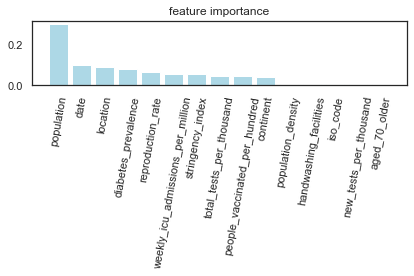

In [18]:
#randomly split data on owid dataset and predict new deaths
train = owid2.drop(['new_cases_per_million','total_cases','new_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths','new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million','tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)

owid2=owid.dropna(subset=['new_deaths_smoothed'])
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

y_train=owid2['new_deaths_smoothed']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train=train
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
# Predicting new cases 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()


LinearRegression 0.05952515281241744
ExtraTreesRegressor 0.9758727938080719
Linear Regression with PolynomialFeatures -0.9113615102781725
Random Forest 0.9769364805908366
Random Forest with scaling 0.9749543336907686
 1) H7_Flag                        0.106418
 2) H6_Flag                        0.094933
 3) E1_Income support              0.080894
 4) H6_Facial Coverings            0.069040
 5) M1_Wildcard                    0.068455
 6) C4_Flag                        0.044259
 7) CountryName                    0.042254
 8) CountryCode                    0.037302
 9) E1_Flag                        0.036898
10) RegionCode                     0.030313
11) ContainmentHealthIndex         0.028507
12) H7_Vaccination policy          0.028383
13) ContainmentHealthIndexForDisplay 0.027349
14) EconomicSupportIndex           0.026291
15) C7_Flag                        0.024558
16) C6_Flag                        0.023450
17) EconomicSupportIndexForDisplay 0.022993
18) C3_Flag                      

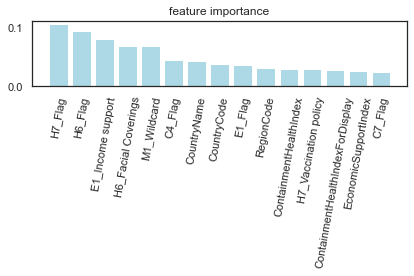

In [43]:
# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()

Average growth factor 2.154281980008477
Average growth factor 2.04183517686709
Average growth factor 1.8088591355698993
Average growth factor 2.154281980008477


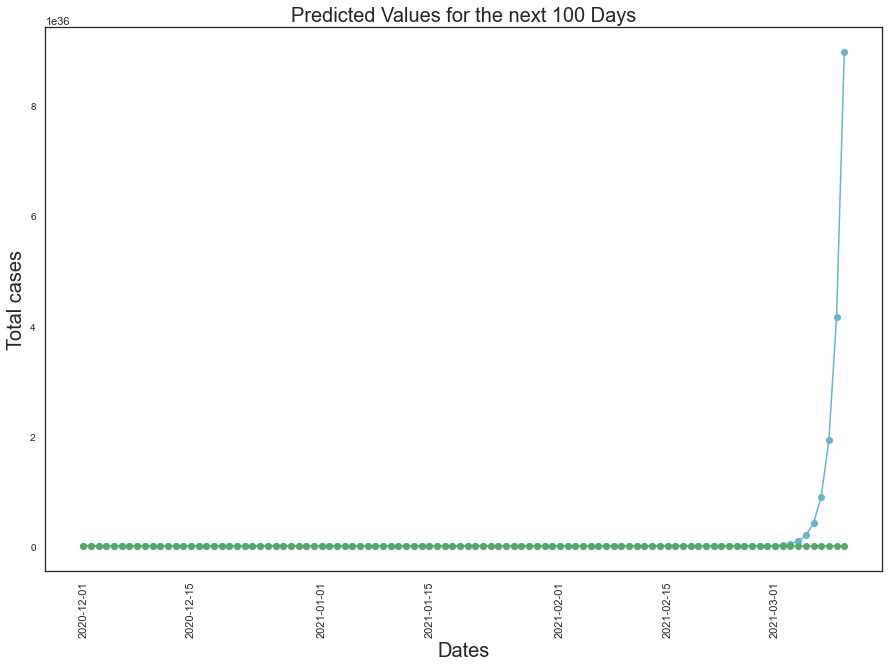

In [7]:
### Growth_factor predicting

startdate = startdate1
def growth_factor(startdate):
    growth_diff = []
    df_filtered = owid[owid.iso_code=='NLD']
    # df_filtered['date'] = pd.to_datetime(df_filtered['date'], format = '%Y-%m-%d').dt.date
    df_filtered1 = df_filtered[df_filtered['date']<startdate]['new_cases']
    for i in range(1,len(df_filtered1)):
        growth_diff.append(df_filtered1.iloc[i] / (df_filtered1.iloc[i-1]+1))

    growth_factor = sum(growth_diff)/len(growth_diff)
    print('Average growth factor',growth_factor)
    return growth_factor
def growth_factor(startdate):
    growth_diff = []
    df_filtered = owid[owid.iso_code=='NLD']
    # df_filtered['date'] = pd.to_datetime(df_filtered['date'], format = '%Y-%m-%d').dt.date
    df_filtered1 = df_filtered[df_filtered['date']<startdate]['new_cases']
    for i in range(1,len(df_filtered1)):
        growth_diff.append(df_filtered1.iloc[i] / (df_filtered1.iloc[i-1]+1))

    growth_factor = sum(growth_diff)/len(growth_diff)
    print('Average growth factor',growth_factor)
    return growth_factor
growth_factor(startdate1)
growth_factor(startdate2)
growth_factor(startdate3)

def growth_factor_predict(startdate, days, growth_factor):
    predicted_cases,prediction_dates = [],[]
    df_filtered = owid[owid.iso_code=='NLD']
    previous_day_cases = df_filtered[df_filtered['date']==startdate]['new_cases']
    for i in range(days):
        predicted_value = previous_day_cases *  growth_factor
        predicted_cases.append(predicted_value)
        previous_day_cases = predicted_value
        date = datetime.datetime.strptime(startdate, '%Y-%m-%d').date() + datetime.timedelta(days=i)
        prediction_dates.append(date)
#         start_date = date
    plt.figure(figsize= (15,10))
    plt.xticks(rotation = 90 ,fontsize = 11)
    plt.yticks(fontsize = 10)
    plt.xlabel("Dates",fontsize = 20)
    plt.ylabel('Total cases',fontsize = 20)
    plt.title(f"Predicted Values for the next {days} Days" , fontsize = 20)
#     print(predicted_cases,)
    ax1 = plt.plot_date(y= predicted_cases,x=prediction_dates,linestyle ='-',color = 'c')
    ax1 = plt.plot_date(y= df_filtered[df_filtered['date']>=startdate]['new_cases'][:days],x=prediction_dates,linestyle ='-',color = 'g')

    return predicted_cases
date = growth_factor_predict(startdate1, 100,growth_factor(startdate1))

In [10]:
#sigmoid fitting 

def sigmoid(t, M, beta, alpha, offset=0):
    alpha += offset
    return M / (1 + np.exp(-beta * (t - alpha)))

def error(x, y, params):
    M, beta, alpha = params
    y_pred = sigmoid(x, M, beta, alpha)

    # apply weight, latest number is more important than past.
    weight = np.arange(len(y_pred)) ** 2
    loss_mse = np.mean((y_pred - y) ** 2 * weight)
    return loss_mse

def gen_random_color(min_value=0, max_value=256) -> str:
    """Generate random color for plotly"""
    r, g, b = np.random.randint(min_value, max_value, 3)
    return f'rgb({r},{g},{b})'

def fit_sigmoid(exclude_days,target_date,var='new_cases'):
    target_country_df_list = []
    pred_df_list = []
    for target_country in country_list:
        print('target_country', target_country)
        # --- Train ---
        target_country_df = owid.query('iso_code == @target_country')

        #train_start_date = target_country_df['date'].min()
        train_start_date = target_country_df.query('new_cases > 1000')['date'].min()
        print(train_start_date)
        train_end_date = pd.to_datetime(target_date) - pd.Timedelta(f'{exclude_days} days')
        target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')
        if len(target_date_df) <= 7:
            print('WARNING: the data is not enough, use 7 more days...')
            train_start_date -= pd.Timedelta('7 days')
            target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')

        confirmed = target_date_df[var].values
        x = np.arange(len(confirmed))

        lossfun = lambda params: error(x, confirmed, params)
        res = sp.optimize.minimize(lossfun, x0=[np.max(confirmed) * 5, 0.04, 2 * len(confirmed) / 3.], method='nelder-mead')
        M, beta, alpha = res.x
        # sigmoid_models[key] = (M, beta, alpha)
        # np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
        
        # --- Pred ---
        pred_start_date = target_country_df['date'].min()
        pred_end_date = pd.to_datetime('2021-8-31')
        days = int((pred_end_date - pred_start_date) / pd.Timedelta('1 days'))
        # print('pred start', pred_start_date, 'end', pred_end_date, 'days', days)
    
        x = np.arange(days)
        offset = (train_start_date - pred_start_date) / pd.Timedelta('1 days')
        print('train_start_date', train_start_date, 'offset', offset, 'params', M, beta, alpha)
        y_pred = sigmoid(x, M, beta, alpha, offset=offset)
        # target_country_df['confirmed_pred'] = y_pred

        all_dates = [pred_start_date + np.timedelta64(x, 'D') for x in range(days)]
        pred_df = pd.DataFrame({
            'date': all_dates,
            'country': target_country,
            'confirmed_pred': y_pred,
        })
    
        target_country_df_list.append(target_country_df)
        pred_df_list.append(pred_df)
    return target_country_df_list, pred_df_list

def plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='',var='new_cases'):
    n_countries = len(country_list)

    # --- Plot ---
    fig = go.Figure()
    error_list = {}
    for i in range(n_countries):
        target_country = country_list[i]
        target_country_df = target_country_df_list[i]
        pred_df = pred_df_list[i]
        length = len(target_country_df[var])
        error_list[country_list[i]]=np.sqrt(metrics.mean_squared_error(target_country_df[var].fillna(0), pred_df['confirmed_pred'][:length].fillna(0)))
        color = gen_random_color(min_value=20)
        # Prediction
        fig.add_trace(go.Scatter(
            x=pred_df['date'], y=pred_df['confirmed_pred'],
            name=f'{target_country}_pred',
            line=dict(color=color, dash='dash')
        ))
    
        # Ground truth
        fig.add_trace(go.Scatter(
            x=target_country_df['date'], y=target_country_df[var],
            mode='markers', name=f'{target_country}_actual',
            line=dict(color=color),
        ))
    fig.update_layout(
        title=title, xaxis_title='Date', yaxis_title='Confirmed cases')
    fig.show()
    return error_list
    
owid['date'] = pd.to_datetime(owid['date'], format = '%Y-%m-%d')
var = 'new_cases_smoothed'
target_country_df_list, pred_df_list = fit_sigmoid(0,'2021-03-01',var)
error_list = plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='Sigmoid predicting',var=var)


target_country NLD
2020-03-26 00:00:00
train_start_date 2020-03-26 00:00:00 offset 28.0 params 6251.764582476735 0.17262357119055438 186.41607453989195
target_country IND
2020-04-06 00:00:00
train_start_date 2020-04-06 00:00:00 offset 67.0 params 32792.44144571211 0.13678232407870383 79.7677333389137
target_country USA
2020-03-16 00:00:00
train_start_date 2020-03-16 00:00:00 offset 54.0 params 161281.2016566701 0.0834891590659706 220.18230345530162
target_country BRA
2020-03-31 00:00:00
train_start_date 2020-03-31 00:00:00 offset 34.0 params 1031783.1952948724 0.003391611899961932 1206.3719398676556


In [12]:
#sigmoid fitting all conturies
def sigmoid(t, M, beta, alpha, offset=0):
    alpha += offset
    return M / (1 + np.exp(-beta * (t - alpha)))

def error(x, y, params):
    M, beta, alpha = params
    y_pred = sigmoid(x, M, beta, alpha)

    # apply weight, latest number is more important than past.
    weight = np.arange(len(y_pred)) ** 2
    loss_mse = np.mean((y_pred - y) ** 2 * weight)
    return loss_mse

def gen_random_color(min_value=0, max_value=256) -> str:
    """Generate random color for plotly"""
    r, g, b = np.random.randint(min_value, max_value, 3)
    return f'rgb({r},{g},{b})'

def fit_sigmoid(exclude_days,target_date,var='new_cases'):
    target_country_df_list = []
    pred_df_list = []
    for target_country in country_list:
        print('target_country', target_country)
        # --- Train ---
        target_country_df = owid.query('iso_code == @target_country')

        #train_start_date = target_country_df['date'].min()
        train_start_date = target_country_df.query('new_cases > 1000')['date'].min()
        print(train_start_date)
        train_end_date = pd.to_datetime(target_date) - pd.Timedelta(f'{exclude_days} days')
        target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')
        if len(target_date_df) <= 7:
            print('WARNING: the data is not enough, use 7 more days...')
            train_start_date -= pd.Timedelta('7 days')
            target_date_df = target_country_df.query('(date >= @train_start_date) & (date <= @train_end_date)')

        confirmed = target_date_df[var].values
        x = np.arange(len(confirmed))

        lossfun = lambda params: error(x, confirmed, params)
        res = sp.optimize.minimize(lossfun, x0=[np.max(confirmed) * 5, 0.04, 2 * len(confirmed) / 3.], method='nelder-mead')
        M, beta, alpha = res.x
        # sigmoid_models[key] = (M, beta, alpha)
        # np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
        
        # --- Pred ---
        pred_start_date = target_country_df['date'].min()
        pred_end_date = pd.to_datetime('2021-12-31')
        days = int((pred_end_date - pred_start_date) / pd.Timedelta('1 days'))
        # print('pred start', pred_start_date, 'end', pred_end_date, 'days', days)

        x = np.arange(days)
        offset = (train_start_date - pred_start_date) / pd.Timedelta('1 days')
        print('train_start_date', train_start_date, 'offset', offset, 'params', M, beta, alpha)
        y_pred = sigmoid(x, M, beta, alpha, offset=offset)
        # target_country_df['confirmed_pred'] = y_pred

        all_dates = [pred_start_date + np.timedelta64(x, 'D') for x in range(days)]
        pred_df = pd.DataFrame({
            'date': all_dates,
            'country': target_country,
            'confirmed_pred': y_pred,
        })

        target_country_df_list.append(target_country_df)
        pred_df_list.append(pred_df)
    return target_country_df_list, pred_df_list

def plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='',var='new_cases'):
    n_countries = len(country_list)

    # --- Plot ---
    fig = go.Figure()

    for i in range(n_countries):
        target_country = country_list[i]
        target_country_df = target_country_df_list[i]
        pred_df = pred_df_list[i]
        color = gen_random_color(min_value=20)
        # Prediction
        fig.add_trace(go.Scatter(
            x=pred_df['date'], y=pred_df['confirmed_pred'],
            name=f'{target_country}_pred',
            line=dict(color=color, dash='dash')
        ))

        # Ground truth
        fig.add_trace(go.Scatter(
            x=target_country_df['date'], y=target_country_df[var],
            mode='markers', name=f'{target_country}_actual',
            line=dict(color=color),
        ))
    fig.update_layout(
        title=title, xaxis_title='Date', yaxis_title='Confirmed cases')
    fig.show()

var = 'new_cases_smoothed'
target_country_df_list, pred_df_list = fit_sigmoid(0,startdate2,var)
plot_sigmoid_fitting(target_country_df_list, pred_df_list, title='Sigmoid predicting',var=var)


target_country NLD
2020-03-26 00:00:00
train_start_date 2020-03-26 00:00:00 offset 28.0 params 7850.91601911908 0.14092965313371886 190.43996546253533
target_country IND
2020-04-06 00:00:00
train_start_date 2020-04-06 00:00:00 offset 67.0 params 49039.061085310575 0.12138432519107734 91.67119062738757
target_country USA
2020-03-16 00:00:00
train_start_date 2020-03-16 00:00:00 offset 54.0 params 283949.38331338565 0.029649893073526213 246.33860893623626
target_country BRA
2020-03-31 00:00:00
train_start_date 2020-03-31 00:00:00 offset 34.0 params 33250.67598131519 0.10666476536072314 54.46835760630624


In [42]:
#randomly split data on oxcg dataset
train2 = oxcgrt.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)

l = LabelEncoder()
X = train2.iloc[:,0].values
train2.iloc[:,0] = l.fit_transform(X.astype(str))
X = train2.iloc[:,1].values
train2.iloc[:,1] = l.fit_transform(X.astype(str))
X = train2.iloc[:,2].values
train2.iloc[:,2] = l.fit_transform(X.astype(str))
X = train2.iloc[:,3].values
train2.iloc[:,3] = l.fit_transform(X.astype(str))
X = train2.iloc[:,4].values
train2.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train2.columns)):
    X = train2.iloc[:,i].values
    train2.iloc[:,i]= l.fit_transform(X.astype(float))

y_train=oxcgrt['ConfirmedCases']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train2.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


LinearRegression 0.054319367854863465
ExtraTreesRegressor 0.9787887280660965
Linear Regression with PolynomialFeatures -0.7612799598722184
Random Forest 0.979728015951284
Random Forest with scaling 0.9824956724666285
 1) M1_Wildcard                    0.146771
 2) H7_Flag                        0.076772
 3) CountryName                    0.072688
 4) CountryCode                    0.071972
 5) Date                           0.059364
 6) H6_Facial Coverings            0.057065
 7) H3_Contact tracing             0.052445
 8) C4_Flag                        0.041363
 9) E1_Flag                        0.038844
10) RegionCode                     0.037740
11) RegionName                     0.030483
12) H1_Flag                        0.025259
13) Jurisdiction                   0.023775
14) C1_Flag                        0.021300
15) C7_Flag                        0.020142
16) EconomicSupportIndexForDisplay 0.019438
17) EconomicSupportIndex           0.017065
18) H6_Flag                        

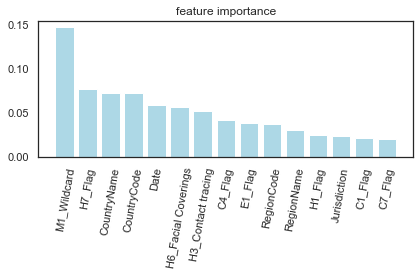

In [47]:
#randomly split data on oxcg dataset and predict new deaths
train2 = oxcgrt.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)

l = LabelEncoder()
X = train2.iloc[:,0].values
train2.iloc[:,0] = l.fit_transform(X.astype(str))
X = train2.iloc[:,1].values
train2.iloc[:,1] = l.fit_transform(X.astype(str))
X = train2.iloc[:,2].values
train2.iloc[:,2] = l.fit_transform(X.astype(str))
X = train2.iloc[:,3].values
train2.iloc[:,3] = l.fit_transform(X.astype(str))
X = train2.iloc[:,4].values
train2.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train2.columns)):
    X = train2.iloc[:,i].values
    train2.iloc[:,i]= l.fit_transform(X.astype(float))

y_train=oxcgrt['ConfirmedDeaths']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train2.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()

In [70]:
# Split datasets through time
startdate = startdate3
train_owid = owid.drop(['new_cases_per_million','total_cases','new_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths','new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million','tests_units'],axis=True)
test = train_owid[train_owid.date>startdate]

train = train_owid[train_owid.date<=startdate]
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)

l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

da= pd.to_datetime(test['date'])
test['date']= da.dt.strftime("%Y%m%d").astype(int)

l = LabelEncoder()
X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))
X = test.iloc[:,1].values
test.iloc[:,1] = l.fit_transform(X.astype(str))
X = test.iloc[:,2].values
test.iloc[:,2] = l.fit_transform(X.astype(str))
for i in range(3, len(test.columns)):
    X = test.iloc[:,i].values
    test.iloc[:,i]= l.fit_transform(X.astype(float))

y_train = owid[owid.date<=startdate]['new_cases_smoothed']
y_test = owid[owid.date>startdate]['new_cases_smoothed']
x_train=train
x_test = test

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')
x_test=test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

owid['date'] = pd.to_datetime(owid['date'], format = '%Y-%m-%d')
train_data=owid2[owid2['date']<startdate]
valid_data=owid2[owid2['date']>startdate]
plt.figure(figsize=(20,7))

train_data.new_cases.plot(label='Train data')
valid_data.new_cases.plot(label='Valid data')
plt.legend(loc='best')


<ipython-input-70-54a72e1ffe82>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-54a72e1ffe82>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

LinearRegression 0.14800554819152856
ExtraTreesRegressor 0.44055316585813953
Linear Regression with PolynomialFeatures -460.33221824821754
Random Forest -0.4938330956541941
Random Forest with scaling -0.5298995404060289
 1) date                           0.228304
 2) population                     0.227432
 3) diabetes_prevalence            0.171458
 4) location                       0.113174
 5) people_vaccinated              0.049402
 6) cardiovasc_death_rate          0.021649
 7) stringency_index               0.014724
 8) positive_rate                  0.014048
 9) iso_code                       0.013037
10) gdp_per_capita                 0.012830
11) icu_patients                   0.011464
12) icu_patients_per_million       0.010905
13) population_density             0.010148
14) tests_per_case                 0.009581
15) human_development_index        0.009561
16) handwashing_facilities         0.008097
17) new_tests_smoothed             0.006843
18) total_tests                 

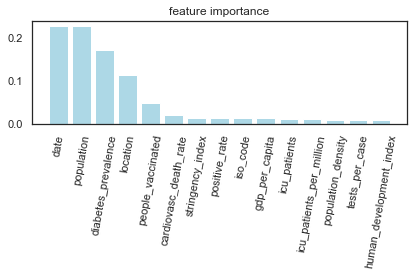

In [71]:
# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)

model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()
    

In [156]:
#prepare data for predicting NL
predict_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','stringency_index']
NLD_data = owid[owid['iso_code']=='NLD'][predict_NLDOWID]

NLD_data1 = NLD_data.fillna(method='pad') 
NLD_data1 = NLD_data1.fillna(method='bfill')

NLD_data2 = NLD_data1.drop(['new_cases','new_deaths'],axis=True)
l = LabelEncoder()

startdate = startdate2
test = NLD_data2[NLD_data1.date>startdate]
train = NLD_data2[NLD_data1.date<=startdate]

X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))

X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))


y_train = NLD_data1[NLD_data1.date<=startdate]['new_deaths']
y_test = NLD_data1[NLD_data1.date>startdate]['new_deaths']
x_train= train
x_test = test

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')
x_test=test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

NLD_data1['date'] = pd.to_datetime(NLD_data1['date'], format = '%Y-%m-%d')
NLD_data1=NLD_data1.set_index(NLD_data1.date)
train_data=NLD_data1[NLD_data1['date']<startdate]
valid_data=NLD_data1[NLD_data1['date']>startdate]

plt.figure(figsize=(20,7))
train_data.new_cases.plot(label='Train data')
valid_data.new_cases.plot(label='Valid data')
plt.legend(loc='best')

# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)

model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

model5 = SVR(kernel = 'linear')
model5.fit(x_train , y_train)
prediction = model5.predict(x_test)
acc=model5.score(x_test,y_test)
print('SVR with linear kernel', acc)
acc_list.append(acc)

model6 = SVR(kernel = 'rbf')
model6.fit(x_train , y_train)
prediction = model6.predict(x_test)
acc=model6.score(x_test,y_test)
print('SVR with rbf kernel', acc)
acc_list.append(acc)



/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



LinearRegression -0.46973460386394894
ExtraTreesRegressor -1.825577131402511
Linear Regression with PolynomialFeatures -10.99916255301179
Random Forest -0.7830149449568642
Random Forest with scaling -1.007357593532444
SVR with linear kernel -139.21473187187186
SVR with rbf kernel -0.35255343038851183
 1) icu_patients                   0.853943
 2) hosp_patients                  0.066373
 3) new_tests_smoothed             0.031116
 4) date                           0.028593
 5) reproduction_rate              0.018299
 6) stringency_index               0.001676


In [ ]:
#split data on oxcg dataset during time and predict confirm cases
oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format = '%Y%m%d')
train2 = oxcgrt.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
drop2 = ['C1_Flag','C2_Flag','C3_Flag','C4_Flag','C5_Flag','C6_Flag','C7_Flag','H1_Flag','H7_Flag','H8_Flag','M1_Wildcard',
        'E4_International support']
train2 = train2.drop(drop2,axis=True)
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
# train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)
startdate=startdate3
test = train2[train2.Date>startdate]
train = train2[train2.Date<=startdate]

l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
X = train.iloc[:,3].values
train.iloc[:,3] = l.fit_transform(X.astype(str))
X = train.iloc[:,4].values
train.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

l = LabelEncoder()
X = test.iloc[:,0].values
test.iloc[:,0] = l.fit_transform(X.astype(str))
X = test.iloc[:,1].values
test.iloc[:,1] = l.fit_transform(X.astype(str))
X = test.iloc[:,2].values
test.iloc[:,2] = l.fit_transform(X.astype(str))
X = test.iloc[:,3].values
test.iloc[:,3] = l.fit_transform(X.astype(str))
X = test.iloc[:,4].values
test.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train.columns)):
    X = test.iloc[:,i].values
    test.iloc[:,i]= l.fit_transform(X.astype(float))

y_train = oxcgrt[oxcgrt.Date<=startdate]['ConfirmedCases']
y_test = oxcgrt[oxcgrt.Date>startdate]['ConfirmedCases']

y_test = y_test.fillna(method='pad') 
y_test = y_test.fillna(method='bfill')

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train =train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

x_test =test.fillna(method='pad') 
x_test = x_test.fillna(method='bfill')

# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)

model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model6 = SVR(kernel = 'rbf')
# model6.fit(x_train , y_train)
# prediction = model6.predict(x_test)
# acc=model6.score(x_test,y_test)
# print('SVR with rbf kernel', acc)
# acc_list.append(acc)


#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=6
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


LinearRegression -0.06906296508160659
ExtraTreesRegressor -0.04825335399954045
Linear Regression with PolynomialFeatures -8413.135036442
Random Forest 0.06099574649834205
Random Forest with scaling 0.0605506351321663


LinearRegression 0.37234161517630315
ExtraTreesRegressor 0.6702927324631636
Linear Regression with PolynomialFeatures -6.592626793199107
Random Forest 0.627556249726647
Random Forest with scaling 0.6079401782881758
 1) population                     0.493108
 2) date                           0.071604
 3) diabetes_prevalence            0.035102
 4) tests_per_case                 0.034465
 5) new_tests_smoothed             0.027772
 6) continent                      0.024518
 7) population_density             0.024038
 8) extreme_poverty                0.022216
 9) stringency_index               0.016472
10) reproduction_rate              0.015897
11) female_smokers                 0.015832
12) cardiovasc_death_rate          0.015428
13) hospital_beds_per_thousand     0.013894
14) new_tests_smoothed_per_thousand 0.013259
15) new_tests_per_thousand         0.012559
16) human_development_index        0.012284
17) median_age                     0.012202
18) total_tests_per_thousand       0

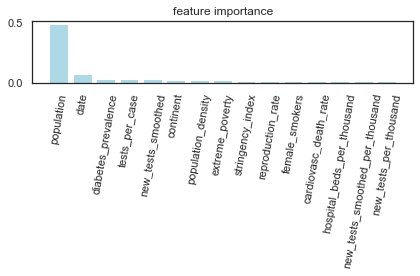

In [64]:
#averge number predict of randomly split data on owid dataset 
train = owid2.drop(['tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)
owid2=owid.dropna(subset=['new_cases_smoothed'])
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))
    
train = train.groupby('iso_code').mean()
y_train=train['new_cases_smoothed']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train = train.drop(['new_cases_per_million','total_cases','new_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths','new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million'],axis=True)

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()

In [26]:
#averge number predict of randomly split data on owid dataset 
train = owid2.drop(['tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)
owid2=owid.dropna(subset=['new_cases_smoothed'])
da= pd.to_datetime(train['date'])
train['total_smoke'] = train['male_smokers']+train['female_smokers']
train['morality'] = train['new_cases_smoothed']/train['total_cases']

# train['date']= da.dt.strftime("%Y%m%d").astype(int)
# train.fillna(0)
# l = LabelEncoder()
# X = train.iloc[:,0].values
# train.iloc[:,0] = l.fit_transform(X.astype(str))
# X = train.iloc[:,1].values
# train.iloc[:,1] = l.fit_transform(X.astype(str))
# X = train.iloc[:,2].values
# train.iloc[:,2] = l.fit_transform(X.astype(str))
# # print(train.date)
# for i in range(3, len(train.columns)):
#     X = train.iloc[:,i].values
#     train.iloc[:,i]= l.fit_transform(X.astype(float))

    
train = train.groupby('iso_code').mean()


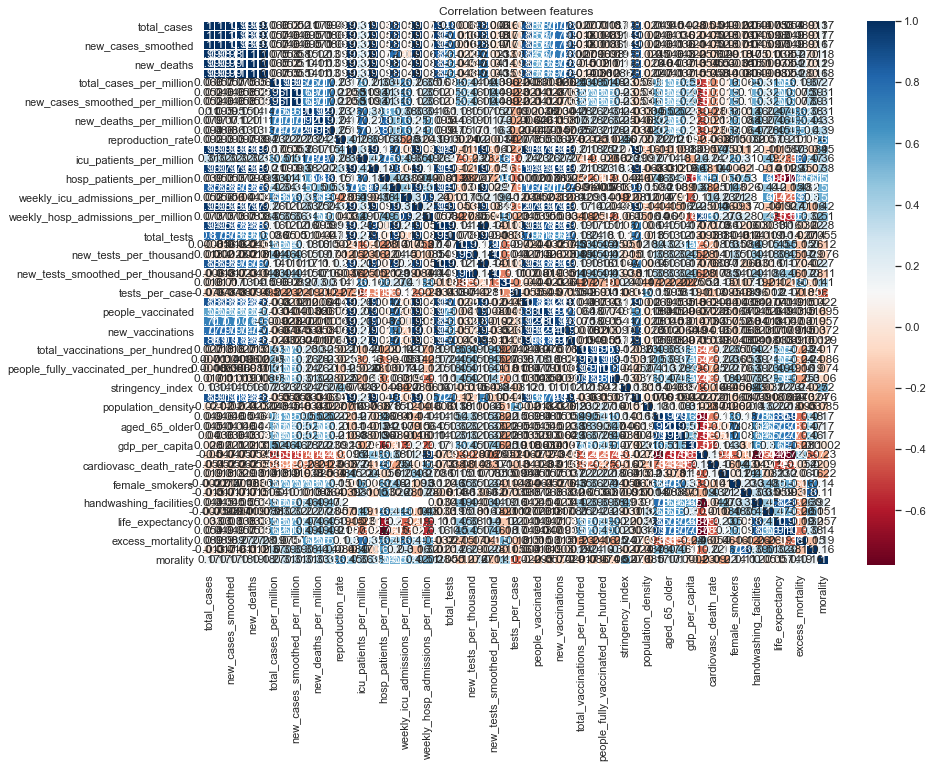

In [28]:
c_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','new_vaccinations_smoothed']

f, ax= plt.subplots(figsize = (14, 10))
corr = train.corr()
# print(corr)
sns.heatmap(corr,cmap='RdBu', linewidths = 0.5, ax = ax,annot=True)
ax.set_title('Correlation between features')
plt.show()
# s = find_corr_sig(train,0.1)

In [29]:
corr['morality']

total_cases                              0.165951
new_cases                                0.166868
new_cases_smoothed                       0.166780
total_deaths                             0.184440
new_deaths                               0.187130
new_deaths_smoothed                      0.176078
total_cases_per_million                  0.272858
new_cases_per_million                    0.310530
new_cases_smoothed_per_million           0.308749
total_deaths_per_million                 0.312474
new_deaths_per_million                   0.330474
new_deaths_smoothed_per_million          0.391532
reproduction_rate                        0.672947
icu_patients                             0.451793
icu_patients_per_million                 0.364433
hosp_patients                            0.379581
hosp_patients_per_million                0.540109
weekly_icu_admissions                    0.546223
weekly_icu_admissions_per_million        0.541185
weekly_hosp_admissions                   0.416897


In [ ]:
predict_NLDOWID = ['date','reproduction_rate','new_cases','new_deaths','icu_patients','hosp_patients','new_tests_smoothed','stringency_index']


In [71]:
#averge number predict of randomly split data on owid dataset 
train = owid2.drop(['tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)
owid2=owid.dropna(subset=['new_cases_smoothed'])
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))

    
train = train.groupby('iso_code').mean()
y_train=train['new_deaths']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train = train.drop(['new_cases_per_million','total_cases','new_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths','new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million'],axis=True)

y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()

LinearRegression 0.3962819845809433
ExtraTreesRegressor 0.18423915797534285
Linear Regression with PolynomialFeatures -10.295678318422656
Random Forest 0.21336470056788992
Random Forest with scaling 0.28825367212666686
 1) reproduction_rate              0.438536
 2) population                     0.112063
 3) date                           0.089001
 4) population_density             0.058737
 5) stringency_index               0.037449
 6) median_age                     0.033926
 7) hospital_beds_per_thousand     0.020120
 8) gdp_per_capita                 0.016851
 9) diabetes_prevalence            0.013784
10) cardiovasc_death_rate          0.013775
11) aged_65_older                  0.013350
12) life_expectancy                0.012906
13) people_vaccinated              0.012473
14) location                       0.011854
15) male_smokers                   0.010505
16) total_vaccinations             0.009020
17) female_smokers                 0.008459
18) extreme_poverty              

LinearRegression -29.838053732063795
ExtraTreesRegressor -0.08971196543672444
Linear Regression with PolynomialFeatures -130.74784509190792
Random Forest -0.07672787675448234
Random Forest with scaling -0.10193095195586954
 1) M1_Wildcard                    0.120847
 2) GovernmentResponseIndexForDisplay 0.086806
 3) H8_Flag                        0.056825
 4) E1_Flag                        0.053010
 5) GovernmentResponseIndex        0.051330
 6) StringencyIndexForDisplay      0.042326
 7) ContainmentHealthIndexForDisplay 0.041305
 8) StringencyLegacyIndexForDisplay 0.041171
 9) ContainmentHealthIndex         0.036440
10) C3_Flag                        0.035748
11) Date                           0.034983
12) C5_Flag                        0.026791
13) C4_Flag                        0.024365
14) C6_Flag                        0.023429
15) C1_Flag                        0.021937
16) StringencyIndex                0.020291
17) C2_Flag                        0.019254
18) C6_Stay at home req

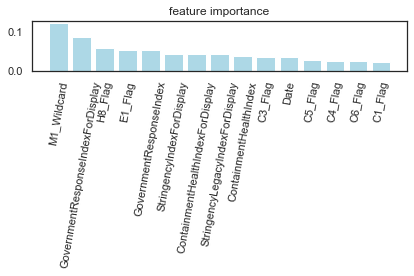

In [77]:
#randomly split data on oxcg dataset and predict new deaths
train2 = oxcgrt.copy()
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)

l = LabelEncoder()
X = train2.iloc[:,0].values
train2.iloc[:,0] = l.fit_transform(X.astype(str))
X = train2.iloc[:,1].values
train2.iloc[:,1] = l.fit_transform(X.astype(str))
X = train2.iloc[:,2].values
train2.iloc[:,2] = l.fit_transform(X.astype(str))
X = train2.iloc[:,3].values
train2.iloc[:,3] = l.fit_transform(X.astype(str))
X = train2.iloc[:,4].values
train2.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train2.columns)):
    X = train2.iloc[:,i].values
    train2.iloc[:,i]= l.fit_transform(X.astype(float))
train2 = train2.groupby('CountryName').mean()


y_train=train2['ConfirmedDeaths']
x_train = train2.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
x_train = x_train.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


# Predicting new cases on oxcg dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
acc_list=[]
model1 = LinearRegression()
model1.fit(x_train , y_train)
prediction = model1.predict(x_test)
acc=model1.score(x_test,y_test)
acc_list.append(acc)
print('LinearRegression',acc)


model22 = Pipeline([('scaler2' , StandardScaler()),
                ('ExtraTreesRegressor: ', ExtraTreesRegressor(n_estimators=5))]) # On competition I set n_estimators=500
model22.fit(x_train , y_train)
prediction = model22.predict(x_test)
acc=model22.score(x_test,y_test)
print('ExtraTreesRegressor',acc)
acc_list.append(acc)

acc_list.append(acc)
model3 = Pipeline([('poly', PolynomialFeatures(degree=2)),
             ('linear', LinearRegression(fit_intercept=False))])
model3.fit(x_train , y_train)
prediction = model3.predict(x_test)
acc=model3.score(x_test,y_test)
print('Linear Regression with PolynomialFeatures',acc)
acc_list.append(acc)

model4 = RandomForestRegressor(n_jobs=-1,n_estimators = 100)
model4.fit(x_train , y_train)
prediction = model4.predict(x_test)
acc=model4.score(x_test,y_test)
print('Random Forest',acc)
acc_list.append(acc)

mode144 = Pipeline([('scaler2' , StandardScaler()),('RandomForestRegressor: ', model4)])
mode144.fit(x_train , y_train)
prediction = mode144.predict(x_test)
acc=mode144.score(x_test,y_test)
print('Random Forest with scaling', acc)
acc_list.append(acc)

# model5 = SVR(kernel = 'linear')
# model5.fit(x_train , y_train)
# prediction = model5.predict(x_test)
# acc=model5.score(x_test,y_test)
# print('SVR with linear kernel', acc)
# acc_list.append(acc)

# model55 = Pipeline([('scaler2', StandardScaler()),
#                    'SVR',SVR(kernel = 'linear')])
# model55.fit(x_train , y_train)
# prediction = model55.predict(x_test)
# acc=model55.score(x_test,y_test)
# print('SVR with scaling', acc)
# acc_list.append(acc)

#plot feature importance
importances = model4.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, x_train.columns[indices[f]], importances[indices[f]]))
plt.title('feature importance')
# plt.figure(figsize=(10,20))
n=15
plt.bar(range(n), importances[indices][:n],color='lightblue',align='center')
plt.xticks(range(n),x_train.columns[indices][:n],rotation=80)
plt.tight_layout()

In [ ]:
#predict country
train = owid.drop(['new_cases_per_million','total_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
                   'total_deaths','total_deaths_per_million',
                   'new_deaths_per_million',
                   'new_deaths_smoothed','new_deaths_smoothed_per_million','tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)

da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))
train = train.fillna(method='pad') 
train = train.fillna(method='bfill')
    
y_train=owid['new_cases']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')

x_train=train
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


In [114]:
#randomly split data on owid dataset
train = owid.drop(['tests_units'],axis=True)
# train = owid.drop(['new_cases_per_million','total_cases','new_cases_smoothed','total_cases_per_million','new_cases_smoothed_per_million',
#                    'total_deaths','total_deaths_per_million',
#                    'new_deaths_per_million',
#                    'new_deaths_smoothed','new_deaths_smoothed_per_million','tests_units'],axis=True)
train.replace([np.inf, -np.inf], np.nan)
da= pd.to_datetime(train['date'])
train['date']= da.dt.strftime("%Y%m%d").astype(int)
# train.fillna(0)
l = LabelEncoder()
X = train.iloc[:,0].values
train.iloc[:,0] = l.fit_transform(X.astype(str))
X = train.iloc[:,1].values
train.iloc[:,1] = l.fit_transform(X.astype(str))
X = train.iloc[:,2].values
train.iloc[:,2] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(3, len(train.columns)):
    X = train.iloc[:,i].values
    train.iloc[:,i]= l.fit_transform(X.astype(float))
# train = train.fillna(method='pad') 
# train = train.fillna(method='bfill')
train = train.dropna()


In [115]:
#randomly split data on oxcg dataset
train2 = oxcgrt.copy()
# train2 = oxcgrt.drop(['ConfirmedCases','ConfirmedDeaths'],axis=True)
train2['Date'] = pd.to_datetime(train2['Date'], format = '%Y%m%d')
# train2['Date']= da.dt.strftime("%Y%m%d").astype(int)
train2.replace([np.inf, -np.inf], np.nan)

l = LabelEncoder()
X = train2.iloc[:,0].values
train2.iloc[:,0] = l.fit_transform(X.astype(str))
X = train2.iloc[:,1].values
train2.iloc[:,1] = l.fit_transform(X.astype(str))
X = train2.iloc[:,2].values
train2.iloc[:,2] = l.fit_transform(X.astype(str))
X = train2.iloc[:,3].values
train2.iloc[:,3] = l.fit_transform(X.astype(str))
X = train2.iloc[:,4].values
train2.iloc[:,4] = l.fit_transform(X.astype(str))
# print(train.date)
for i in range(5, len(train2.columns)):
    X = train2.iloc[:,i].values
    train2.iloc[:,i]= l.fit_transform(X.astype(float))

y_train=oxcgrt['ConfirmedCases']
y_train = y_train.fillna(method='pad') 
y_train = y_train.fillna(method='bfill')
x_train=train2.fillna(method='pad') 
x_train = x_train.fillna(method='bfill')

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
